In [173]:
import juliacall
import numpy as np
import fit_modeler
import evolve_binary
import pandas as pd
import time, os
import surrogate
from astropy import constants as const
import matplotlib.pyplot as plt

from mcfacts.vis import plotting
from mcfacts.vis import styles

np.set_printoptions(legacy='1.13')

### Should work for everyone ###
# Current directory
#HERE=$(shell pwd)
#/Users/sray/Documents/1Saavik_Barry/test_mcfacts
#os.getcwd()
HERE = '/Users/sray/Documents/1Saavik_Barry/test_mcfacts'

#### Scripts ####
# Change final number of zeros depending on how many galaxies are initialized (example: 1 galaxy - 'runs/gal0'; 10 galaxies - 'runs/gal00'; 100 galaxies -'runs/gal000')
MCFACTS_RUNS_GAL = HERE + '/runs/gal000'
MCFACTS_RUNS = HERE + '/runs'

# Code that will match the number of objects and galaxies being run without the user having to change it manually
dir_path = (MCFACTS_RUNS_GAL)
objects = int((len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]) - 2)/3)
galaxies = len(next(os.walk(MCFACTS_RUNS))[1])

# Change value of n - zfill(n) - to match the order of magnitude of number of galaxies being run
gal = [str(i).zfill(3) for i in range(galaxies)]
obj = [str(i) for i in range(objects)]
runs = [[] for _ in range(len(gal))]

for i in range(len(gal)):
    for j in range(len(obj)):
        temp = '/Users/sray/Documents/1Saavik_Barry/test_mcfacts/runs/gal' + gal[i] + '/output_bh_binary_' + obj[j] + '.dat'
        runs[i].append(temp)

#with open("Output.txt", "w") as text_file:
    #text_file.write(str(gal))
    
# Setting up surrogate model
surrogate = fit_modeler.GPRFitters.read_from_file(f"surrogate.joblib")

# Creating a hard coded binary seperation to speed up the surrogate model 
# ========= NEEDS CHANGES: change hard set binary value to change depending on the mass ratio ============
def new_bin_sep(freq, i):
    active_bin = pd.read_csv(i, delimiter=' ', header = 0)
    mass_1 = active_bin['mass_1']
    mass_2 = active_bin['mass_2']
    #print(mass_1)
    G = const.G.value
    M_dot = 2e30
    grav_freq = freq
    
    #print('mass_1: ', active_bin['mass_1'])
    #print('grav_freq: ', active_bin['gw_freq'])
    
    a_bin = ((G * (mass_1 + mass_2) * M_dot * np.pi**2) / grav_freq**2) ** (1/3)
    #a_bin = ((G * (mass_1 + mass_2) * M_dot) / (16 * grav_freq**2 * np.pi**2))**1/3
    a_bin_rg = a_bin / 1.5e11
    return a_bin_rg

total_mass_final = []
total_spin_final = []
total_velocity_final = []
total_radius_final = []
total_gen_final = []
total_boa_final = []

num_of_obj_mergers = []
num_of_gal_mergers = []

sur_time_start = time.time()

# Starting loops to determine binary merger events 
# Beginning with a new galaxy and iterating through each of the timesteps within the galaxy
for i in range(len(gal)):
    merger_counter_gal = []
    print('===================================   NEW GALAXY   =================================')
    for j in range(len(obj)):
        if j == 0:
            continue
        merger_counter_obj = []
        total_start_mass1 = []
        total_start_mass2 = []
        total_start_spin1 = []
        total_start_spin2 = []
        
        #The following logic systems use the current binary as the base for checks
        active_bin = pd.read_csv(runs[i][j], delimiter=' ', header = 0)
        print('----------------     NEW TIMESTEP     ----------------')
        mass_final = []
        spin_final = []
        velocity_final = []
        radius_final = []
        gen_final = []
        boa_final = []
        
        starting_mass1 = []
        starting_mass2 = []
        starting_spin1 = []
        starting_spin2 = []
        
        # This checks if the current timestep is empty
        if active_bin.empty:
            print('Galaxy ', gal[i], ' and run ', obj[j])
            print('file is empty. Checking for previous binaries and moving onto next system')
            act_bin_prev = pd.read_csv(runs[i][j-1], delimiter=' ', header = 0)
            
            bh_prev = act_bin_prev['id_num']
            bh = active_bin['id_num']
            
            #This loop checks if there are any previously generated binaries
            # If there are any previously merged binaries, then this must mean those binaries have merged
            #  since the current timestep is empty.
            if bh_prev.empty:
                print('no previously merged binaries')
            else:
                for k, values in enumerate(bh_prev):
                    print('binary ', values, ' has merged...beginning surrogate model')
                    
                    
                    #merger_counter_obj.append(obj[j])
                    mass_1 = act_bin_prev['mass_1'][k]
                    mass_2 = act_bin_prev['mass_2'][k]
                    spin_1_mag = act_bin_prev['spin_1'][k]
                    spin_2_mag = act_bin_prev['spin_2'][k]
                    spin_angle_1 = act_bin_prev['spin_angle_1'][k]
                    spin_angle_2 = act_bin_prev['spin_angle_2'][k]
                    radius = act_bin_prev['bin_orb_a'][k]
                    gen_1 = act_bin_prev['gen_1'][k]
                    gen_2 = act_bin_prev['gen_2'][k]
                    phi_12 = spin_angle_2 - spin_angle_1
                    # This should be in units of mass_1 + mass_2
                    bin_sep = 1000
                    bin_inc = [0, 0, 1]
                    bin_phase = 0
                    # These next three are used to correct the remnant velocity;
                    # If they are None, no correction is applied.
                    bin_orb_a = None
                    mass_SMBH = None
                    spin_SMBH = None
                    
                    #print('surrogate test: ', mass_1, mass_2, spin_1_mag, spin_2_mag, spin_angle_1, spin_angle_2, phi_12)
                    
                    surrogate = fit_modeler.GPRFitters.read_from_file(f"surrogate.joblib")

                    start = time.time()
                    M_f, spin_f, v_f = evolve_binary.evolve_binary(
                        mass_1,
                        mass_2,
                        spin_1_mag,
                        spin_2_mag,
                        spin_angle_1,
                        spin_angle_2,
                        phi_12,
                        bin_sep,
                        bin_inc,
                        bin_phase,
                        bin_orb_a,
                        mass_SMBH,
                        spin_SMBH,
                        surrogate,
                        verbose=True,
                    )
                    end = time.time()
                    
                    run_time = end - start

                    mass_final.append(M_f)
                    spin_final.append(spin_f)
                    velocity_final.append(v_f)
                    radius_final.append(radius)
                    bin_orb_a = act_bin_prev['bin_orb_a'][k]
                    boa_final.append(bin_orb_a)
                    
                    #print('x_final')
                    #print(mass_final)
                    #print(spin_final)
                    #print(velocity_final)
                    #print(radius_final)
                    # Checking generation values to ensure that correct generation of remnant is allocated
                    if int(gen_1) == 1 or int(gen_2) == 1:
                        gen_final.append(gen_1 + gen_2)
                    else:
                        if int(gen_1) > int(gen_2):
                            gen_final.append(gen_1 + 1)
                        elif int(gen_2) > int(gen_1):
                            gen_final.append(gen_2 + 1)
                        else:
                            gen_final.append(gen_1 + 1)
                        
                    print("M_f = ", M_f)
                    print("spin_f = ", spin_f)
                    print("v_f = ", v_f)
                    print("Merger took ", run_time, " seconds")
        
        else:
            print('Galaxy ', gal[i], ' and run ', obj[j])
            print('binary found at galaxy ', gal[i], ' and binary ', obj[j])
            act_bin_prev = pd.read_csv(runs[i][j-1], delimiter=' ', header = 0)
            
            mass_1 = act_bin_prev['mass_1']
            mass_2 = act_bin_prev['mass_2']
            spin_1 = act_bin_prev['spin_1']
            spin_2 = act_bin_prev['spin_2']
            spin_angle_1 = act_bin_prev['spin_angle_1']
            spin_angle_2 = act_bin_prev['spin_angle_2']
            
            bh_prev = act_bin_prev['id_num'].values
            bh = active_bin['id_num'].values
            
            #This loop check to see if any binaries have formed
            for value in bh:
                if act_bin_prev.empty:
                    print('binary ', value, ' has formed')
                elif value not in bh_prev:
                    print('binary ', value, ' has formed')
                else:
                    print('binary ', value, ' has not yet mergered')
            
            for k, value in enumerate(bh_prev):
                if value not in bh:
                    print('binary ', value, ' has merged...beginning surrogate model')
                    #merger_counter_obj.append(obj[j])
                    mass_1 = act_bin_prev['mass_1'][k]
                    mass_2 = act_bin_prev['mass_2'][k]
                    spin_1_mag = act_bin_prev['spin_1'][k]
                    spin_2_mag = act_bin_prev['spin_2'][k]
                    spin_angle_1 = act_bin_prev['spin_angle_1'][k]
                    spin_angle_2 = act_bin_prev['spin_angle_2'][k]
                    radius = act_bin_prev['bin_orb_a'][k]
                    gen_1 = act_bin_prev['gen_1'][k]
                    gen_2 = act_bin_prev['gen_2'][k]
                    phi_12 = spin_angle_2 - spin_angle_1

                    # This should be in units of mass_1 + mass_2
                    bin_sep = 1000
                    bin_inc = [0, 0, 1]
                    bin_phase = 0
                    # These next three are used to correct the remnant velocity;
                    # If they are None, no correction is applied.
                    bin_orb_a = None
                    mass_SMBH = None
                    spin_SMBH = None

                    #print('surrogate test: ', mass_1, mass_2, spin_1_mag, spin_2_mag, spin_angle_1, spin_angle_2, phi_12)

                    surrogate = fit_modeler.GPRFitters.read_from_file(f"surrogate.joblib")

                    start = time.time()
                    M_f, spin_f, v_f = evolve_binary.evolve_binary(
                        mass_1,
                        mass_2,
                        spin_1_mag,
                        spin_2_mag,
                        spin_angle_1,
                        spin_angle_2,
                        phi_12,
                        bin_sep,
                        bin_inc,
                        bin_phase,
                        bin_orb_a,
                        mass_SMBH,
                        spin_SMBH,
                        surrogate,
                        verbose=True,
                    )
                    end = time.time()
                    
                    run_time = end - start

                    # These values are the surrogate outputs for each binary system that goes through a merger event
                    mass_final.append(M_f)
                    spin_final.append(spin_f)
                    velocity_final.append(v_f)
                    radius_final.append(radius)
                    bin_orb_a = act_bin_prev['bin_orb_a'][k]
                    boa_final.append(bin_orb_a)
                    
                    #print('x_final')
                    #print(mass_final)
                    #print(spin_final)
                    #print(velocity_final)
                    #print(radius_final)
                    
                    # Checking generation values to ensure that correct generation of remnant is allocated
                    if int(gen_1) == 1 or int(gen_2) == 1:
                        gen_final.append(gen_1 + gen_2)
                    else:
                        if int(gen_1) > int(gen_2):
                            gen_final.append(gen_1 + 1)
                        elif int(gen_2) > int(gen_1):
                            gen_final.append(gen_2 + 1)
                        else:
                            gen_final.append(gen_1 + 1)
                    
                    # ============= Need to incorporate starting mass to determine the initial mass compared to final mass after merger =============
                    #starting_mass1.append(mass_1)
                    #starting_mass2.append(mass_2)
                    #starting_spin1.append(spin_1)
                    #starting_spin2.append(spin_2)#
                        
                    print("M_f = ", M_f)
                    print("spin_f = ", spin_f)
                    print("v_f = ", v_f)
                    print("Merger took ", run_time, " seconds")
        #merger_counter_gal.append(merger_counter_obj)
                    
        #merger_counter_gal.append(merger_counter_obj)
        #print('galaxy ', gal[i], ' had mergers at timesteps ', merger_counter_gal)
        
        # Sorting all the merger event properties into a collective list that contains all merger event properties 
        total_mass_final.append(mass_final)
        total_spin_final.append(spin_final)
        total_velocity_final.append(velocity_final)
        total_radius_final.append(radius_final)
        total_gen_final.append(gen_final)
        total_boa_final.append(boa_final)
        
        #print('total_x_final')
        #print(len(total_mass_final))
        #print(len(total_spin_final))
        #print(len(total_velocity_final))
        #print(len(total_gen_final))
        #total_start_mass1.append(starting_mass1)
        #total_start_mass2.append(starting_mass2)
        #total_start_spin1.append(starting_spin1)
        #total_start_spin2.append(starting_spin2)

# print(total_mass_final)
# print(total_spin_final)len(
# print(total_velocity_final)
# print(total_radius_final)
# print('\n')
# print(total_start_mass1)
# print(total_start_mass2)
# print(total_start_spin1)
# print(total_start_spin2)

sur_time_end = time.time()
final_time = sur_time_end - sur_time_start
print('//////////////////////////////////////////                FINAL RUN TIME : ', int(final_time/60), 'min -', int(final_time % 60), 'sec                 //////////////////////////////////////////')

# Since there are many timesteps that do not have merger events, there is an empty list that is pulled for the merger
# The reduced properties removes the empty lists and creates a final list with no empty sections of data
reduced_mass_final = []
reduced_spin_final = []
reduced_velocity_final = []
reduced_radius_final = []
reduced_gen_final = []
reduced_boa_final = []

for i in range(len(total_mass_final)):
    if total_mass_final[i] != []:
        reduced_mass_final.append(total_mass_final[i])
for i in range(len(total_spin_final)):
    if total_spin_final[i] != []:
        reduced_spin_final.append(total_spin_final[i])
for i in range(len(total_velocity_final)):
    if total_velocity_final[i] != []:
        reduced_velocity_final.append(total_velocity_final[i])
for i in range(len(total_radius_final)):
    if total_radius_final[i] != []:
        reduced_radius_final.append(total_radius_final[i])
for i in range(len(total_gen_final)):
    if total_gen_final[i] != []:
        reduced_gen_final.append(total_gen_final[i])
for i in range(len(total_boa_final)):
    if total_boa_final[i] != []:
        reduced_boa_final.append(total_boa_final[i])

        
#print('reduced_x_final')
#print(reduced_mass_final)
#print(reduced_gen_final)
#print(len(reduced_spin_final))
#print(len(reduced_velocity_final))
#print(len(reduced_radius_final))
#print(len(reduced_radius_final))
# Now that we have reduced properties, that are arranged in multidimensional arrays, for each of the binaries, we need to put them into a single large binary 
# that allows us to be able to plot the values and get a visualization on how the data appears
plot_mass = []
for i in range(len(reduced_mass_final)):
    for j in range(len(reduced_mass_final[i])):
        plot_mass.append(reduced_mass_final[i][j])
# print(plot_mass)

plot_spin = []
for i in range(len(reduced_spin_final)):
    for j in range(len(reduced_spin_final[i])):
        plot_spin.append(reduced_spin_final[i][j])
# print(plot_spin)

plot_velocity = []
for i in range(len(reduced_velocity_final)):
    for j in range(len(reduced_velocity_final[i])):
        plot_velocity.append(reduced_velocity_final[i][j])
# print(plot_velocity)

plot_radius = []
for i in range(len(reduced_radius_final)):
    for j in range(len(reduced_radius_final[i])):
        plot_radius.append(reduced_radius_final[i][j])
# print(plot_radius)

plot_gen = []
for i in range(len(reduced_gen_final)):
    for j in range(len(reduced_gen_final[i])):
        plot_gen.append(reduced_gen_final[i][j])
#print(plot_gen)

plot_boa = []
for i in range(len(reduced_boa_final)):
    for j in range(len(reduced_boa_final[i])):
        plot_boa.append(reduced_boa_final[i][j])
#print(plot_boa)

#print('plot_x')
#print(len(plot_gen))
#print(len(plot_mass))
#print(len(plot_radius))
#print(len(plot_spin))
#print(len(plot_velocity))

# Converting spin_1 magnitude values into cartesian values
chi_mag = [[] for _ in range(len(plot_spin))] 

for i in range(len(chi_mag)):
    for j in range(len(plot_spin[i])):
        chi_mag[i] = np.sqrt(plot_spin[i][0]**2 + plot_spin[i][1]**2 + plot_spin[i][2]**2)
#print(len(chi_mag))

# Converting spin_1 magnitude values into cartesian values
vel_mag = [[] for _ in range(len(plot_velocity))] 

for i in range(len(vel_mag)):
    vel_mag[i] = np.linalg.norm(plot_velocity[i]) * const.c.value / 1000
# print(vel_mag)

#print(len(vel_mag))

===================================   NEW GALAXY   =================================
----------------     NEW TIMESTEP     ----------------
Galaxy  000  and run  1
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries
----------------     NEW TIMESTEP     ----------------
Galaxy  000  and run  2
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries
----------------     NEW TIMESTEP     ----------------
Galaxy  000  and run  3
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries
----------------     NEW TIMESTEP     ----------------
Galaxy  000  and run  4
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries
----------------     NEW TIMESTEP     ----------------
Galaxy  000  and run  5
file is empty. Checking for previous binaries and moving onto next system
no previously merged binaries


/Users/sray/Documents/1Saavik_Barry/test_mcfacts/src/mcfacts/external/evolve_binary/fit_modeler.py:20: UserWarning: Parameters (1.1378640299122631, -0.91137170750242635, 0.02267089910015694, 0.21709289246088642, -0.062543248711389998, 0.0015557995374002424, 0.014824245068873365) are outside of the fit range!
  warnings.warn(
/Users/sray/Documents/1Saavik_Barry/test_mcfacts/src/mcfacts/external/evolve_binary/fit_modeler.py:20: UserWarning: Parameters (1.1378640299122631, -0.91137170750242635, 0.02267089910015694, 0.21709289246088642, -0.062543248711389998, 0.0015557995374002424, 0.014824245068873365) are outside of the fit range!
  warnings.warn(
/Users/sray/Documents/1Saavik_Barry/test_mcfacts/src/mcfacts/external/evolve_binary/fit_modeler.py:20: UserWarning: Parameters (1.1378640299122631, -0.91137170750242635, 0.02267089910015694, 0.21709289246088642, -0.062543248711389998, 0.0015557995374002424, 0.014824245068873365) are outside of the fit range!
  warnings.warn(
/Users/sray/Documen

M_f =  182.636477561
spin_f =  [ 0.60796787  0.04597002  0.52526879]
v_f =  [-0.0053581   0.0006823  -0.00279656]
Merger took  0.030838966369628906  seconds
----------------     NEW TIMESTEP     ----------------
Galaxy  011  and run  47
binary found at galaxy  011  and binary  47
binary  231.0  has not yet mergered
binary  236.0  has formed
----------------     NEW TIMESTEP     ----------------
Galaxy  011  and run  48
binary found at galaxy  011  and binary  48
binary  231.0  has not yet mergered
binary  236.0  has not yet mergered
binary  237.0  has formed
----------------     NEW TIMESTEP     ----------------
Galaxy  011  and run  49
binary found at galaxy  011  and binary  49
binary  231.0  has not yet mergered
binary  236.0  has not yet mergered
binary  237.0  has not yet mergered
binary  238.0  has formed
===================================   NEW GALAXY   =================================
----------------     NEW TIMESTEP     ----------------
Galaxy  012  and run  1
file is empty

/Users/sray/Documents/1Saavik_Barry/test_mcfacts/src/mcfacts/external/evolve_binary/fit_modeler.py:20: UserWarning: Parameters (0.95005321191897052, -0.7869668966018416, 0.010228739534076554, 0.13646713339590003, -0.08784444458992402, 0.0011417734940387964, 0.015116297846138708) are outside of the fit range!
  warnings.warn(
/Users/sray/Documents/1Saavik_Barry/test_mcfacts/src/mcfacts/external/evolve_binary/fit_modeler.py:20: UserWarning: Parameters (0.95005321191897052, -0.7869668966018416, 0.010228739534076554, 0.13646713339590003, -0.08784444458992402, 0.0011417734940387964, 0.015116297846138708) are outside of the fit range!
  warnings.warn(
/Users/sray/Documents/1Saavik_Barry/test_mcfacts/src/mcfacts/external/evolve_binary/fit_modeler.py:20: UserWarning: Parameters (0.95005321191897052, -0.7869668966018416, 0.010228739534076554, 0.13646713339590003, -0.08784444458992402, 0.0011417734940387964, 0.015116297846138708) are outside of the fit range!
  warnings.warn(
/Users/sray/Documen

mass_1 < mass_2! Flipping black hole labels.
Evolving binary...
Evolving binary to merger using PN equations...
Evolving binary through merger with surrogate...
M_f =  56.3605612386
spin_f =  [ 0.00409741 -0.00594714  0.64695694]
v_f =  [-0.00030667  0.00035069 -0.00011411]
Merger took  0.04095792770385742  seconds
----------------     NEW TIMESTEP     ----------------
Galaxy  076  and run  45
binary found at galaxy  076  and binary  45
binary  222.0  has not yet mergered
binary  229.0  has not yet mergered
binary  236.0  has not yet mergered
binary  237.0  has not yet mergered
binary  238.0  has formed
binary  239.0  has formed
binary  240.0  has formed
----------------     NEW TIMESTEP     ----------------
Galaxy  076  and run  46
binary found at galaxy  076  and binary  46
binary  222.0  has not yet mergered
binary  229.0  has not yet mergered
binary  236.0  has not yet mergered
binary  238.0  has not yet mergered
binary  239.0  has not yet mergered
binary  240.0  has not yet merger

┌ Warning: 
│ This system is likely to encounter the up-down instability in the frequency
│ range (Ω₊, Ω₋)=(0.0016262090316004221, 0.037094042256639044), which corresponds to
│ PN velocity parameters (v₊, v₋)=(0.35260684226871847, 1.0).
│ This is a true physical instability, not just a numerical issue.  Despite the
│ fact that the initial conditions contain very small precession, the system will
│ likely evolve to have very large precession.  See `up_down_instability` docs
│ for details.
│ 
│ Parameters:
│   M₁ = 13.613073274478927
│   M₂ = 13.345433783915908
│   χ⃗₁ =  + 0.008820082106741197𝐢 - 0.0004850417595920164𝐣 + 0.09155760400956883𝐤
│   χ⃗₂ =  - 0.0017525752248629188𝐢 + (9.637916751763263e-5)𝐣 - 0.011526282846303724𝐤
│   R = rotor(1.0 + 0.0𝐢 + 0.0𝐣 + 0.0𝐤)
│   v = 0.1622653324407844
│   v₁ = 0.0
│   vₑ = 1.0
└ @ PostNewtonian ~/.julia/packages/PostNewtonian/Ntoxm/src/dynamics/up_down_instability.jl:69


In [203]:
from mcfacts.vis import data
from mcfacts.vis import plotting
from mcfacts.vis import styles
import matplotlib.ticker as mticker

# Use the McFACTS plot style
plt.style.use("mcfacts.vis.mcfacts_figures")

figsize = "apj_col"


In [204]:
g1_mask = (gen_1 == 1) & (gen_2 == 1)
g2_mask = ((gen_1 == 2) | (gen_2 == 2)) & ((gen_1 <= 2) & (gen_2 <= 2))
gX_mask = (gen_1 >= 3) | (gen_2 >= 3)

In [205]:
g1_plot_mass = []
g2_plot_mass = []
gx_plot_mass = []

for i in range(len(plot_gen)):
    if plot_gen[i] == 2.:
        g1_plot_mass.append(plot_mass[i])
    elif plot_gen[i] == 3.:
        g2_plot_mass.append(plot_mass[i])
    elif plot_gen[i] > 3.:
        gx_plot_mass.append(plot_mass[i])


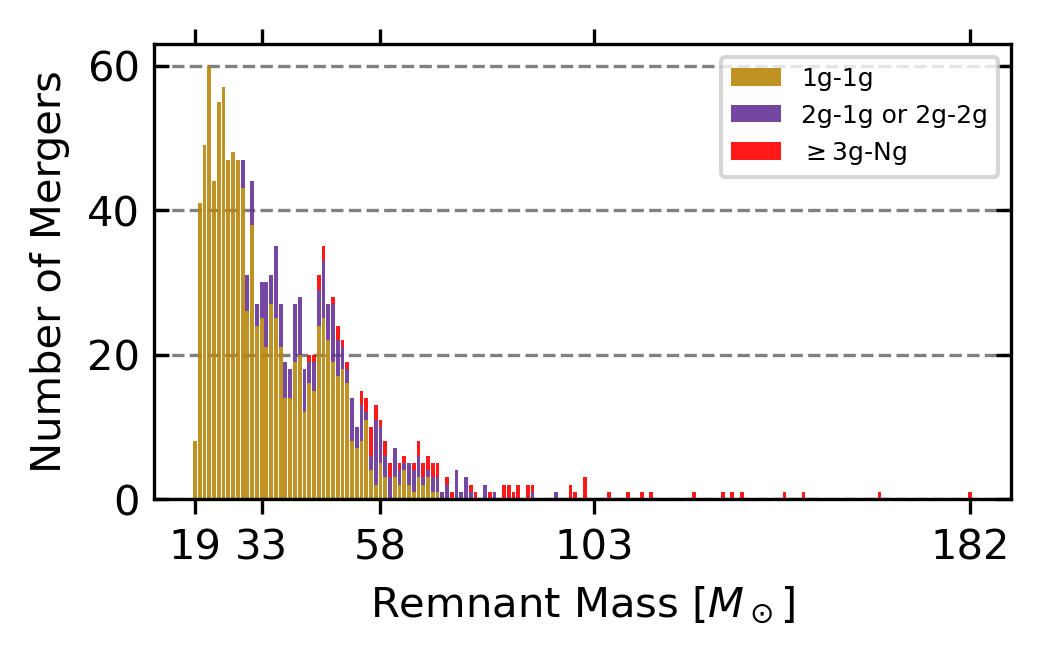

In [206]:
fig = plt.figure(figsize=plotting.set_size(figsize))
#counts, bins = np.histogram(mergers[:, 2])
# plt.hist(bins[:-1], bins, weights=counts)
bins = np.arange(int(np.min(plot_mass)), int(np.max(plot_mass)) + 2, 1)

hist_data = [g1_plot_mass, g2_plot_mass, gx_plot_mass]
hist_label = ['1g-1g', '2g-1g or 2g-2g', r'$\geq$3g-Ng']
hist_color = [styles.color_gen1, styles.color_gen2, styles.color_genX]

plt.hist(hist_data, bins=bins, align='left', color=hist_color, alpha=0.9, rwidth=0.8, label=hist_label, stacked=True)

plt.ylabel('Number of Mergers')
plt.xlabel(r'Remnant Mass [$M_\odot$]')
#plt.xscale('log')
svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
svf_ax.tick_params(axis='x', direction='out', which='both')
#plt.grid(True, color='gray', ls='dashed')
svf_ax.yaxis.grid(True, color='gray', ls='dashed')

plt.xticks(np.geomspace(int(np.min(plot_mass)), int(np.max(plot_mass)), 5).astype(int))
#plt.xticks(np.geomspace(20, 200, 5).astype(int))

svf_ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
svf_ax.xaxis.set_minor_formatter(mticker.NullFormatter())

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

In [207]:
g1_plot_boa = []
g2_plot_boa = []
gx_plot_boa = []

for i in range(len(plot_gen)):
    if plot_gen[i] == 2.:
        g1_plot_boa.append(plot_boa[i])
    elif plot_gen[i] == 3.:
        g2_plot_boa.append(plot_boa[i])
    elif plot_gen[i] > 3.:
        gx_plot_boa.append(plot_boa[i])


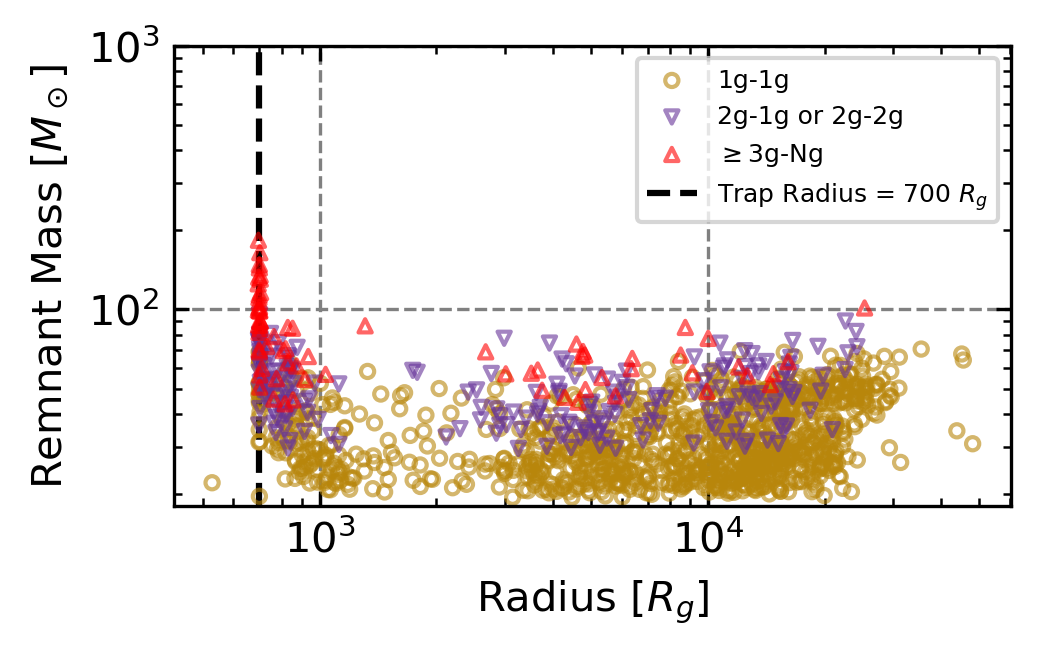

In [208]:
trap_radius = 700

# plt.title('Migration Trap influence')
for i in range(len(plot_boa)):
    if plot_boa[i] < 10.0:
        plot_boa[i] = 10.0

# Separate generational subpopulations
gen1_orb_a = g1_plot_boa
gen2_orb_a = g2_plot_boa
genX_orb_a = gx_plot_boa
gen1_mass = g1_plot_mass
gen2_mass = g2_plot_mass
genX_mass = gx_plot_mass
fig = plt.figure(figsize=plotting.set_size(figsize))
plt.scatter(gen1_orb_a, gen1_mass,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolors="none",
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

plt.scatter(gen2_orb_a, gen2_mass,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolors="none",
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

plt.scatter(genX_orb_a, genX_mass,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolors="none",
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

plt.axvline(trap_radius, color='k', linestyle='--', zorder=0,
            label=f'Trap Radius = {trap_radius} ' + r'$R_g$')

# plt.text(650, 602, 'Migration Trap', rotation='vertical', size=18, fontweight='bold')
plt.ylabel(r'Remnant Mass [$M_\odot$]')
plt.xlabel(r'Radius [$R_g$]')
plt.xscale('log')
plt.yscale('log')

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

plt.ylim(18, 1000)

svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
plt.grid(True, color='gray', ls='dashed')

In [209]:
g1_plot_kick = []
g2_plot_kick = []
gx_plot_kick = []

for i in range(len(plot_gen)):
    if plot_gen[i] == 2.:
        g1_plot_kick.append(vel_mag[i])
    elif plot_gen[i] == 3.:
        g2_plot_kick.append(vel_mag[i])
    elif plot_gen[i] > 3.:
        gx_plot_kick.append(vel_mag[i])


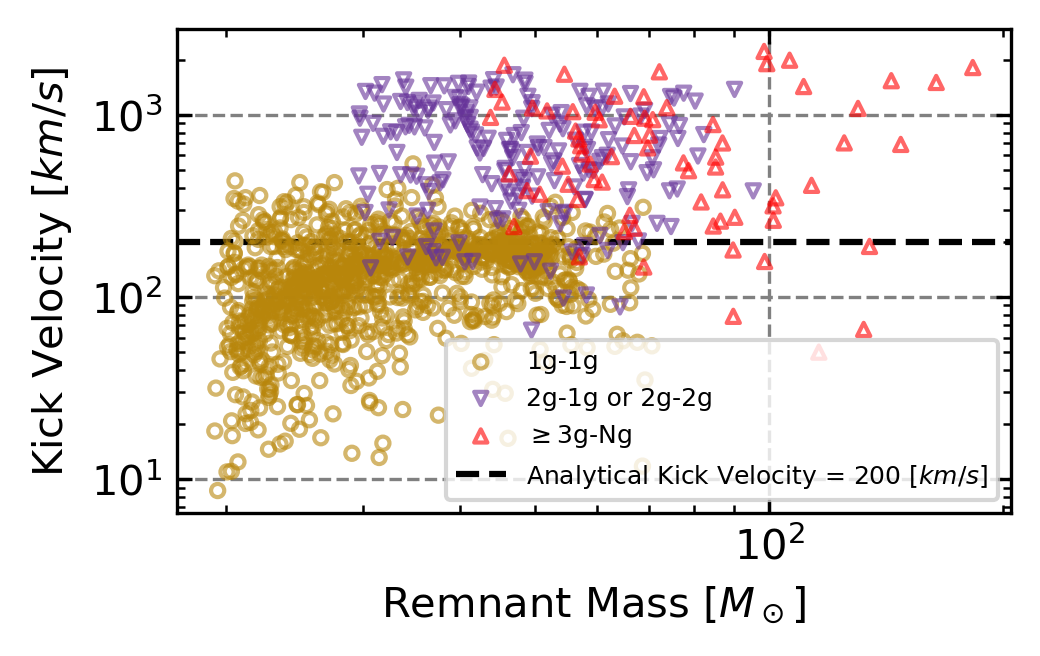

In [219]:
v_kick = 200

# Separate generational subpopulations
gen1_mass = g1_plot_mass
gen2_mass = g2_plot_mass
genX_mass = gx_plot_mass
gen1_kick = g1_plot_kick
gen2_kick = g2_plot_kick
genX_kick = gx_plot_kick
fig = plt.figure(figsize=plotting.set_size(figsize))
plt.scatter(gen1_mass, gen1_kick,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolors="none",
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

plt.scatter(gen2_mass, gen2_kick,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolors="none",
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

plt.scatter(genX_mass, genX_kick,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolors="none",
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

plt.axhline(v_kick, color='k', linestyle='--', zorder=0,
            label=f'Analytical Kick Velocity = {v_kick} ' + r'$[km/s]$')

# plt.text(650, 602, 'Migration Trap', rotation='vertical', size=18, fontweight='bold')
plt.xlabel(r'Remnant Mass [$M_\odot$]')
plt.ylabel(r'Kick Velocity [$km/s$]')
plt.xscale('log')
plt.yscale('log')

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.ylim(18, 1000)

svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
plt.grid(True, color='gray', ls='dashed')

In [211]:
g1_plot_spin = []
g2_plot_spin = []
gx_plot_spin = []

for i in range(len(plot_gen)):
    if plot_gen[i] == 2.:
        g1_plot_spin.append(chi_mag[i])
    elif plot_gen[i] == 3.:
        g2_plot_spin.append(chi_mag[i])
    elif plot_gen[i] > 3.:
        gx_plot_spin.append(chi_mag[i])


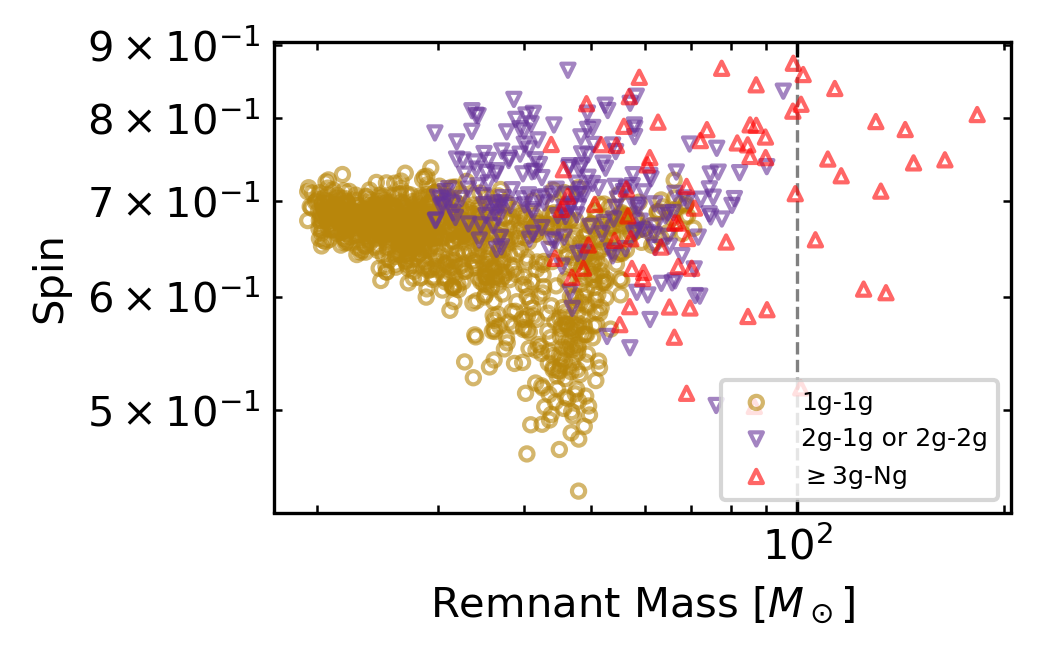

In [212]:
# Separate generational subpopulations
gen1_mass = g1_plot_mass
gen2_mass = g2_plot_mass
genX_mass = gx_plot_mass
gen1_spin = g1_plot_spin
gen2_spin = g2_plot_spin
genX_spin = gx_plot_spin
fig = plt.figure(figsize=plotting.set_size(figsize))
plt.scatter(gen1_mass, gen1_spin,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolors="none",
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

plt.scatter(gen2_mass, gen2_spin,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolors="none",
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

plt.scatter(genX_mass, genX_spin,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolors="none",
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

# plt.text(650, 602, 'Migration Trap', rotation='vertical', size=18, fontweight='bold')
plt.xlabel(r'Remnant Mass [$M_\odot$]')
plt.ylabel(r'Spin')
plt.xscale('log')
plt.yscale('log')

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.ylim(18, 1000)

svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
plt.grid(True, color='gray', ls='dashed')

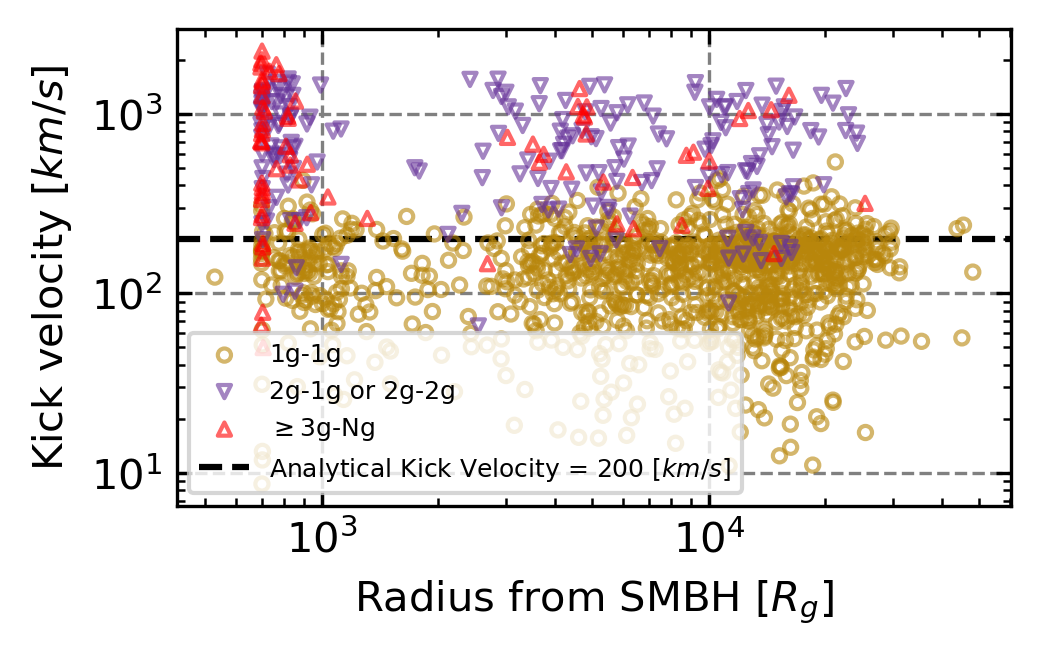

In [220]:
trap_radius = 700

'''# plt.title('Migration Trap influence')
for i in range(len(plot_boa)):
    if plot_boa[i] < 10.0:
        plot_boa[i] = 10.0'''

# Separate generational subpopulations
gen1_boa = g1_plot_boa
gen2_boa = g2_plot_boa
genX_boa = gx_plot_boa
gen1_kick = g1_plot_kick
gen2_kick = g2_plot_kick
genX_kick = gx_plot_kick
fig = plt.figure(figsize=plotting.set_size(figsize))
plt.scatter(gen1_boa, gen1_kick,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolors="none",
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

plt.scatter(gen2_boa, gen2_kick,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolors="none",
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

plt.scatter(genX_boa, genX_kick,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolors="none",
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

plt.axhline(v_kick, color='k', linestyle='--', zorder=0,
            label=f'Analytical Kick Velocity = {v_kick} ' + r'$[km/s]$')

# plt.text(650, 602, 'Migration Trap', rotation='vertical', size=18, fontweight='bold')
plt.xlabel(r'Radius from SMBH [$R_g$]')
plt.ylabel(r'Kick velocity [$km/s$]')
plt.xscale('log')
plt.yscale('log')

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.ylim(18, 1000)

svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
plt.grid(True, color='gray', ls='dashed')

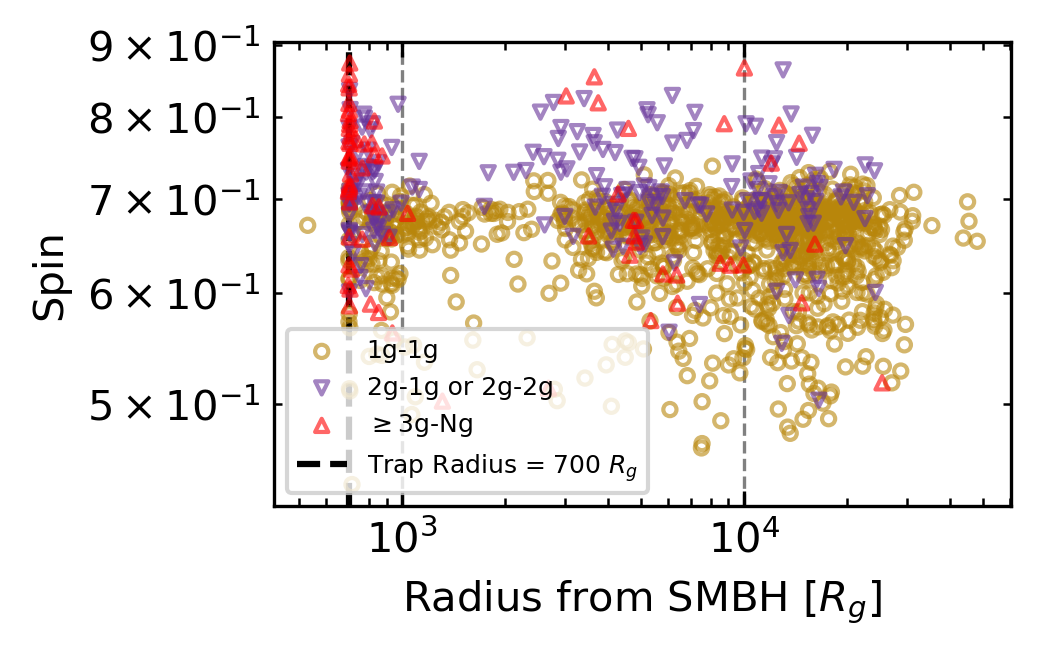

In [215]:
trap_radius = 700

'''# plt.title('Migration Trap influence')
for i in range(len(plot_boa)):
    if plot_boa[i] < 10.0:
        plot_boa[i] = 10.0'''

# Separate generational subpopulations
gen1_boa = g1_plot_boa
gen2_boa = g2_plot_boa
genX_boa = gx_plot_boa
gen1_spin = g1_plot_spin
gen2_spin = g2_plot_spin
genX_spin = gx_plot_spin
fig = plt.figure(figsize=plotting.set_size(figsize))
plt.scatter(gen1_boa, gen1_spin,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolors="none",
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

plt.scatter(gen2_boa, gen2_spin,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolors="none",
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

plt.scatter(genX_boa, genX_spin,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolors="none",
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

plt.axvline(trap_radius, color='k', linestyle='--', zorder=0,
            label=f'Trap Radius = {trap_radius} ' + r'$R_g$')

# plt.text(650, 602, 'Migration Trap', rotation='vertical', size=18, fontweight='bold')
plt.xlabel(r'Radius from SMBH [$R_g$]')
plt.ylabel(r'Spin')
plt.xscale('log')
plt.yscale('log')

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.ylim(18, 1000)

svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
plt.grid(True, color='gray', ls='dashed')

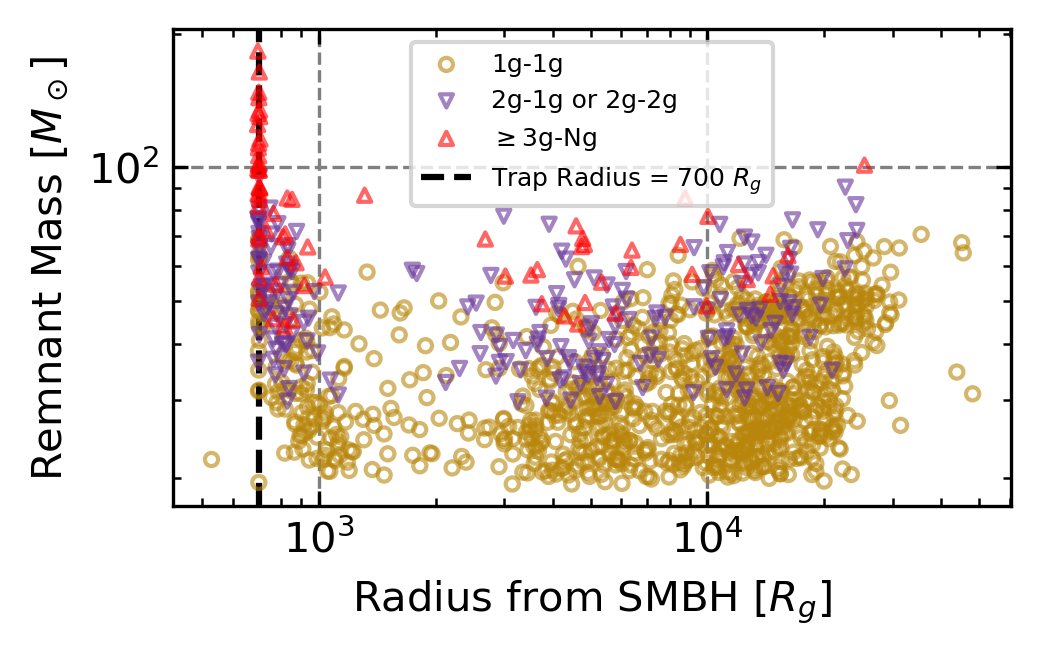

In [216]:
trap_radius = 700

'''# plt.title('Migration Trap influence')
for i in range(len(plot_boa)):
    if plot_boa[i] < 10.0:
        plot_boa[i] = 10.0'''

# Separate generational subpopulations
gen1_boa = g1_plot_boa
gen2_boa = g2_plot_boa
genX_boa = gx_plot_boa
gen1_mass = g1_plot_mass
gen2_mass = g2_plot_mass
genX_mass = gx_plot_mass
fig = plt.figure(figsize=plotting.set_size(figsize))
plt.scatter(gen1_boa, gen1_mass,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolors="none",
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

plt.scatter(gen2_boa, gen2_mass,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolors="none",
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

plt.scatter(genX_boa, genX_mass,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolors="none",
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

plt.axvline(trap_radius, color='k', linestyle='--', zorder=0,
            label=f'Trap Radius = {trap_radius} ' + r'$R_g$')

# plt.text(650, 602, 'Migration Trap', rotation='vertical', size=18, fontweight='bold')
plt.xlabel(r'Radius from SMBH [$R_g$]')
plt.ylabel(r'Remnant Mass [$M_\odot$]')
plt.xscale('log')
plt.yscale('log')

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.ylim(18, 1000)

svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
plt.grid(True, color='gray', ls='dashed')

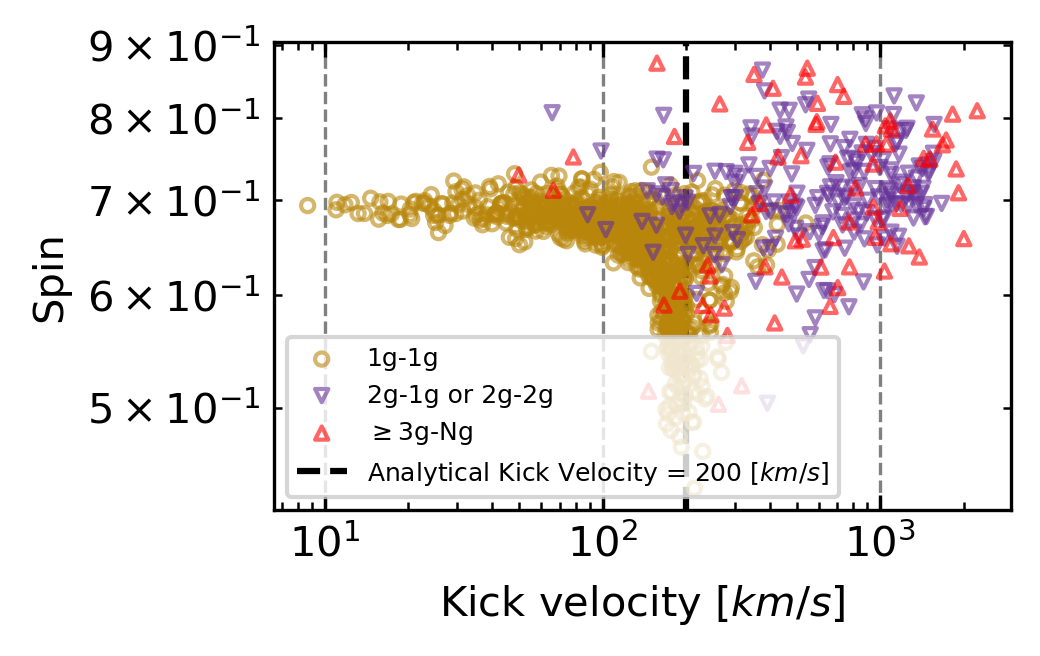

In [221]:
trap_radius = 700

'''# plt.title('Migration Trap influence')
for i in range(len(plot_boa)):
    if plot_boa[i] < 10.0:
        plot_boa[i] = 10.0'''

# Separate generational subpopulations
gen1_kick = g1_plot_kick
gen2_kick = g2_plot_kick
genX_kick = gx_plot_kick
gen1_spin = g1_plot_spin
gen2_spin = g2_plot_spin
genX_spin = gx_plot_spin
fig = plt.figure(figsize=plotting.set_size(figsize))
plt.scatter(gen1_kick, gen1_spin,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolors="none",
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

plt.scatter(gen2_kick, gen2_spin,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolors="none",
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

plt.scatter(genX_kick, genX_spin,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolors="none",
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

plt.axvline(v_kick, color='k', linestyle='--', zorder=0,
            label=f'Analytical Kick Velocity = {v_kick} ' + r'$[km/s]$')

# plt.text(650, 602, 'Migration Trap', rotation='vertical', size=18, fontweight='bold')
plt.xlabel(r'Kick velocity [$km/s$]')
plt.ylabel(r'Spin')
plt.xscale('log')
plt.yscale('log')

if figsize == 'apj_col':
    plt.legend(fontsize=6)
elif figsize == 'apj_page':
    plt.legend()

#plt.ylim(18, 1000)

svf_ax = plt.gca()
svf_ax.set_axisbelow(True)
plt.grid(True, color='gray', ls='dashed')

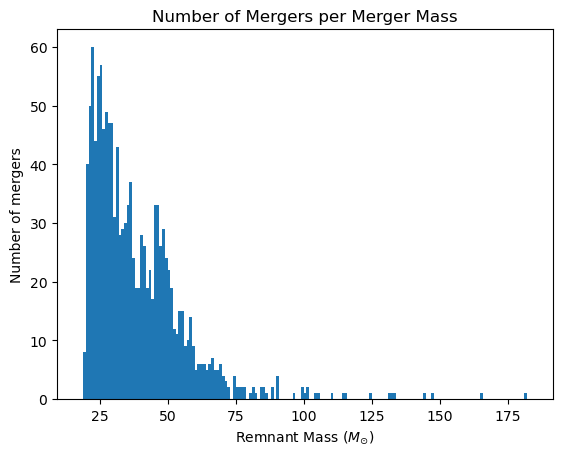

In [89]:
plt.hist(plot_mass, num_mergers)
plt.xlabel('Remnant ' r'Mass ($M_{\odot}$)')
plt.ylabel('Number of mergers')
plt.xlim([np.min(plot_mass) - 10, np.max(plot_mass)+10])
plt.title('Number of Mergers per Merger Mass')
plt.show()

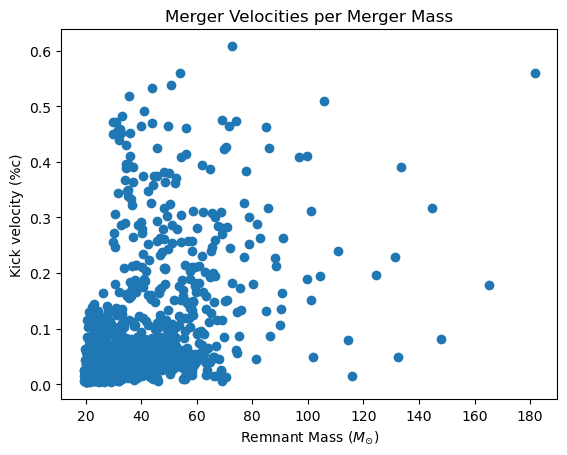

In [90]:
plt.scatter(plot_mass, vel_mag)
plt.xlabel('Remnant ' r'Mass ($M_{\odot}$)')
plt.ylabel('Kick velocity (%c)')
plt.title('Merger Velocities per Merger Mass')
plt.show()

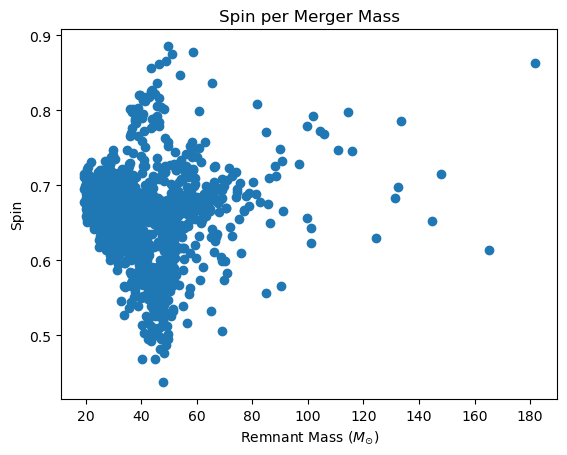

In [91]:

plt.scatter(plot_mass, chi_mag)
plt.xlabel('Remnant ' r'Mass ($M_{\odot}$)')
plt.ylabel('Spin')
plt.title('Spin per Merger Mass')
plt.show()

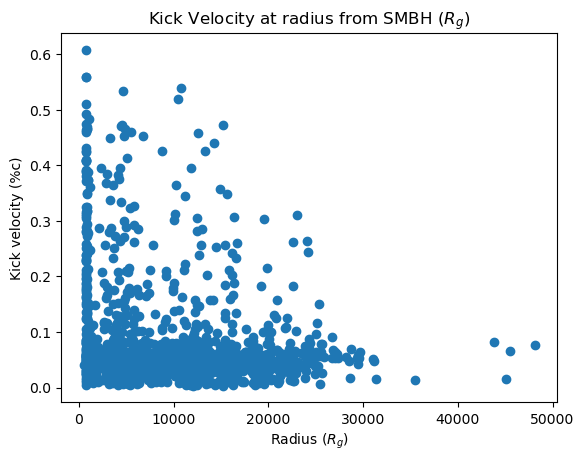

In [92]:
plt.scatter(plot_radius, vel_mag)
plt.xlabel('Radius ' r'($R_g$)')
plt.ylabel('Kick velocity (%c)')
plt.title('Kick Velocity at radius from SMBH ('r'$R_g$'')')
plt.show()

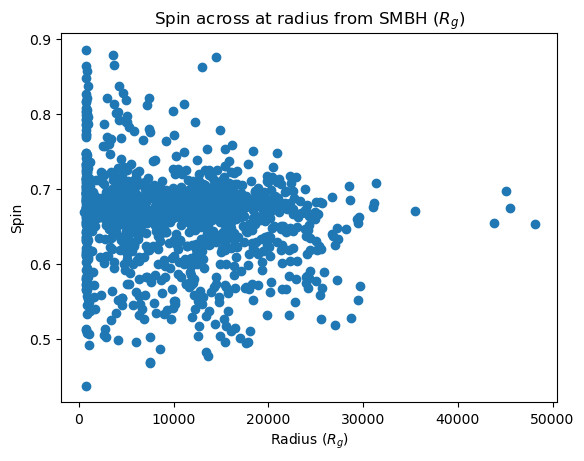

In [93]:
plt.scatter(plot_radius, chi_mag)
plt.xlabel('Radius ' r'($R_g$)')
plt.ylabel('Spin')
plt.title('Spin across at radius from SMBH ('r'$R_g$'')')
plt.show()

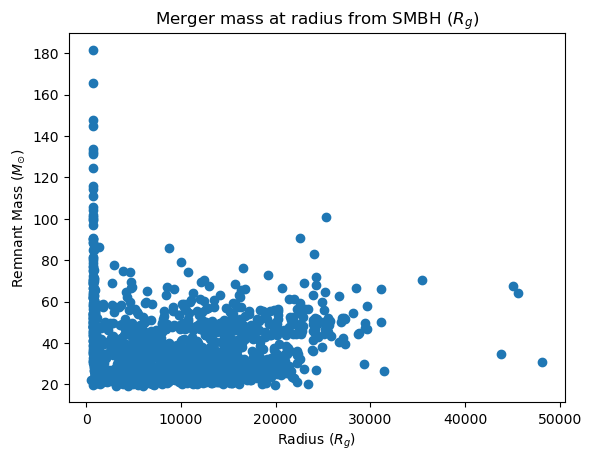

In [94]:
plt.scatter(plot_radius, plot_mass)
plt.xlabel('Radius ' r'($R_g$)')
plt.ylabel('Remnant ' r'Mass ($M_{\odot}$)')
plt.title('Merger mass at radius from SMBH ('r'$R_g$'')')
plt.show()